# بسم الله الرحمن الرحيم

## Problem Statement

Train a deep learning model to find and classify objects in an image to its corresponding object class using Convolutional Neural Networks (CNN).

## Dataset Description

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

>**The label classes in the dataset are:**
>>
1. airplane
2. automobile
3. bird
4. cat
5. deer
6. dog
7. frog
8. horse
9. ship
10. truck


### Importing Libraries


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.experimental import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from keras.utils import plot_model

from six.moves import cPickle

import warnings
warnings.filterwarnings('ignore')

### Loading the data

In [ ]:
def get_batch(filename):
    with open(filename, 'rb') as file:
        data = cPickle.load(file, encoding='latin1')
        return np.array(data['data']), np.array(data['labels'])


In [ ]:
path = '/content/drive/MyDrive/cifar-10-batches-py'
def load_dataset():
    X = []
    Y = []

    for batch_number in range(1, 6):
        x, y = get_batch(path+f'/data_batch_{batch_number}')
        X.append(x)
        Y.append(y)

    X_train, y_train = np.concatenate(X), np.concatenate(Y)
    X_test, y_test = get_batch(path+'/test_batch')
    return X_train, y_train, X_test, y_test

In [ ]:
classes = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

X_train, y_train, X_test, y_test = load_dataset()
image = X_train[1]

# vector [R,R,R .. R, G,G,G .. G, B,B,B .. B]
image

#### By Notcing The Image In Dataset Images Is Flatten as vector

When you try to display a flattened image in Python, it may not appear as expected because a flattened image loses its original dimensions and structure.

Flattening an image means converting it from a multi-dimensional array (usually 2D or 3D) into a 1D array or vector. This process typically happens when you **want** to feed the image data into machine learning algorithms or perform some mathematical operations on the pixel values.

When you flatten an image, you lose information about its width, height, and color channels. As a result, when you try to display it, you're essentially displaying a 1D array of pixel values as if it were a 2D or 3D image, which can lead to unexpected or unrecognizable visual output.

If you want to display a flattened image properly, you need to know its original dimensions (width, height, and number of color channels) and reshape it back to those dimensions before displaying it.

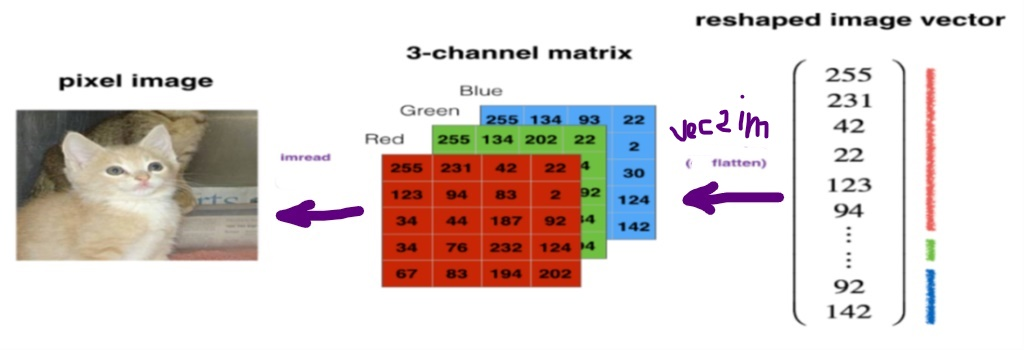

image stored as matrix (2-dimn) every cell in matrix contain 3-values for each 3-color [Red, Green, Blue] so the shape of every Image(x, y, 3) not (3, x, y)

so we need to reshape image from vector to (32, 32, 3)


<!--
```
def modifyImage(image):
    new_image = np.arange(32 * 32 * 3).reshape(32, 32,3)
    for i in range(32*32):
        new_image[i//32, i%32, 0] = image[i]
        new_image[i//32, i%32, 1] = image[i + (32 * 32)]
        new_image[i//32, i%32, 2] = image[i + (2 * 32 * 32)]
    return new_image
image = modifyImage(image)
plt.imshow(image)
plt.show()
``` -->

In [ ]:
def vec2image(data):
    data_shaped = data.reshape(data.shape[0], 3, 32, 32)
    # now we want swap x,z to get valid image
    data_swaped = np.swapaxes(data_shaped, 1, 3)
    # rotate image clockwise
    data_rot = np.array([np.rot90(img, k=-1) for img in data_swaped])
    return data_rot

In [ ]:
X_train = vec2image(X_train)
X_test = vec2image(X_test)

In [ ]:
plt.imshow(X_train[1])
plt.show()

In [ ]:
print('The shape of train:',X_train.shape)
print('The shape of train_label:',y_train.shape)
print('---------------------------------------')
print('The shape of test:',X_test.shape)
print('The shape of train_label:',y_test.shape)

### Visualizing the training *data*

In [ ]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

for i in range(25):

    plt.subplot(5, 5, i + 1)

    plt.imshow(X_train[i])

    plt.title(classes[int(y_train[i])], fontsize=12)

    plt.axis('off')


show frequency count for every category in **training_data**




In [ ]:
label, count = np.unique(y_train, return_counts=True)
uni = pd.DataFrame(data=count, index=classes, columns=['count'])


In [ ]:
plt.figure(figsize=(10, 4), dpi=150)
sns.barplot(data=uni, x=uni.index, y=count, palette='icefire', width=0.5)
plt.title('Class distribution in training set',fontsize=15)
plt.show()

show frequency count for every category in **testing data**

In [ ]:
label, count = np.unique(y_test, return_counts=True)
uni = pd.DataFrame(data=count, index=classes, columns=['count'])

In [ ]:
plt.figure(figsize=(10, 4), dpi=150)
sns.barplot(data=uni, x=uni.index, y=count,palette='icefire', width=0.5)
plt.title('Class distribution in test set',fontsize=15)
plt.show()

### Preparing the data for modeling
`def normalize_data(data):` normalize images pixel values between 0 -> 1

---
`def to_categori(data): converts label into one-hot encoded vectors, where each class label is represented as a binary vector with a '1' in the corresponding class index.`

In [ ]:
def normalize_data(data):
    return data / 255

def to_categori(data):
    return to_categorical(data, num_classes=10)

X_train = normalize_data(X_train)
X_test = normalize_data(X_test)

cat_y_train = to_categori(y_train)
cat_y_test = to_categori(y_test)

In [ ]:
input_shape = X_train[0].shape
input_shape

### Data Augmentation



In [ ]:
batch_size = 32
data_generator = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator = data_generator.flow(X_train, cat_y_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

## Building the Convolutional Neural Network (CNN)


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss') < 0.4):
            print('\n:) Loss is low so cancelling training. !!~!')
            self.model.stop_training = True

my_callback = myCallback()

#### Model

In [ ]:
model = tf.keras.Sequential([

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=input_shape, activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    # Pooling layer
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    # Dropout layers
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    # Fully Connected Layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
])

In [ ]:
# model.summary()
plot_model(model, show_shapes=True, show_layer_names=True, to_file='CNN.png')

In [ ]:
history = model.fit(
    train_generator,
    epochs=100,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_test, cat_y_test),
    # callbacks=[my_callback],
    batch_size=batch_size,
)

#### Evaluating the model

In [ ]:
model.evaluate(X_train, cat_y_train)

In [ ]:

plt.figure(figsize=(8, 12))

plt.subplot(4, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution',fontsize=10)
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution', fontsize=10)
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution', fontsize=10)
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution', fontsize=10)
plt.legend()

In [ ]:
# evaluate with testing date
evaluation = model.evaluate(X_test, cat_y_test)

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
cm = confusion_matrix(y_test, y_pred)

In [ ]:
# figure size and increase dpi for better resolution
plt.figure(figsize=(12,10), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 0.8)
ax = sns.heatmap(cm, annot=True, fmt='d', )

# set x-axis label and ticks.
ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(classes)

# set y-axis label and ticks
ax.set_ylabel("Actual", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(classes)

# set plot title
ax.set_title("Confusion Matrix", fontsize=14, pad=20)

plt.show()

In [ ]:
print(classification_report(y_test, y_pred))


#### Save The Model

In [ ]:
model.save('image_classifications_model.h5')
print(':) model saved')

#### Load The Model

In [ ]:
new_model = tf.keras.models.load_model('image_classifications_model.h5')
print(':) model loaded')

In [ ]:
# new_model.summary()

In [ ]:
def predictImg(index):
    res = new_model.predict(np.array([X_train[index]]))
    res = np.argmax(res)
    plt.imshow(X_train[index])
    plt.axis('off')
    plt.show()
    print('Actual Category     |=>', classes[y_train[index]])
    print('Predicted Category  |=>', classes[res])

In [ ]:
predictImg(100)

In [ ]:
predictImg(30)

In [ ]:
predictImg(50)

#:) Thank You ❤